## Forecast

### Data

In [ ]:
# 1. Data
trans_path = '/content/transaction_data_monthly_sales_by_locationid.csv'
loc_path = '/content/transaction_data_location_info.csv'
reported_path = '/content/reported_numbers.xlsx'

reported = pd.read_excel(reported_path)
locinfo = pd.read_csv(loc_path)
monthly = pd.read_csv(trans_path)

# 2. Basic preprocessing
# Ensure date types
reported["period_end_dt"] = pd.to_datetime(reported["period_end_dt"])

locinfo["est_open_date"] = pd.to_datetime(locinfo["est_open_date"])
locinfo["est_close_date"] = pd.to_datetime(locinfo["est_close_date"])

monthly["period_start"] = pd.to_datetime(monthly["period_start"])
monthly["period_end"] = pd.to_datetime(monthly["period_end"])

# Keep only Party City symbol just in case there is other data
monthly_pc = monthly[monthly["symbol"] == "NYSE:PRTY"].copy()



### Regression based

In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
# -------------------------------------------------------------------
# 3. Build quarterly sales per store
# -------------------------------------------------------------------

# Quarter period and quarter end date
monthly_pc["qtr"] = monthly_pc["period_start"].dt.to_period("Q")
monthly_pc["quarter_end_dt"] = monthly_pc["qtr"].dt.to_timestamp("Q")

# Month index for counting months with sales
monthly_pc["month"] = monthly_pc["period_start"].dt.month

# Aggregate to quarter-level per store
quarter_df = (
    monthly_pc
    .groupby(["locationid", "qtr", "quarter_end_dt"], as_index=False)
    .agg(
        quarter_sales=("amount", "sum"),
        months_with_sales=("month", "nunique"),
    )
)

# -------------------------------------------------------------------
# 4. Join each quarter with its prior-year quarter for the same store
# -------------------------------------------------------------------

# Prior-year quarter end date (same calendar quarter one year before)
quarter_df["prior_quarter_end_dt"] = quarter_df["quarter_end_dt"] - pd.DateOffset(years=1)

# Make a "prior" table to join on
prior_df = quarter_df[["locationid", "quarter_end_dt", "quarter_sales", "months_with_sales"]].copy()
prior_df = prior_df.rename(
    columns={
        "quarter_end_dt": "prior_quarter_end_dt",
        "quarter_sales": "quarter_sales_prior",
        "months_with_sales": "months_with_sales_prior",
    }
)

# Join current quarter row with prior-year quarter row for the same store
merged = quarter_df.merge(
    prior_df,
    on=["locationid", "prior_quarter_end_dt"],
    how="left",
)

# -------------------------------------------------------------------
# 5. Compute quarter start dates and attach store open/close info
# -------------------------------------------------------------------

# Current quarter start and prior-year quarter start
merged["qtr_period"] = merged["quarter_end_dt"].dt.to_period("Q")
merged["quarter_start_dt"] = merged["qtr_period"].dt.start_time

merged["prior_qtr_period"] = merged["prior_quarter_end_dt"].dt.to_period("Q")
merged["prior_quarter_start_dt"] = merged["prior_qtr_period"].dt.start_time

# Attach store open/close dates
merged2 = merged.merge(
    locinfo[["locationid", "est_open_date", "est_close_date"]],
    on="locationid",
    how="left",
)

# -------------------------------------------------------------------
# 6. Define comparable stores
# -------------------------------------------------------------------

# Must have prior-year quarter sales
merged2["has_prior"] = merged2["quarter_sales_prior"].notna()

# Require 3 months of sales in current and prior quarter (you can relax this if desired)
merged2["full_quarter_current"] = merged2["months_with_sales"] >= 3
merged2["full_quarter_prior"] = merged2["months_with_sales_prior"] >= 3

# Store must be open before prior-year quarter starts
merged2["open_before_prior_q"] = merged2["est_open_date"] <= merged2["prior_quarter_start_dt"]

# Store must not be closed before the current quarter ends
merged2["not_closed_by_current_q_end"] = merged2["est_close_date"] >= merged2["quarter_end_dt"]

# Final comparable flag
merged2["is_comparable"] = (
    merged2["has_prior"]
    & merged2["full_quarter_current"]
    & merged2["full_quarter_prior"]
    & merged2["open_before_prior_q"]
    & merged2["not_closed_by_current_q_end"]
)

# -------------------------------------------------------------------
# 7. Compute sample Same Store Sales YoY per quarter (across comparable stores)
# -------------------------------------------------------------------

comp_quarter = (
    merged2[merged2["is_comparable"]]
    .groupby("quarter_end_dt", as_index=False)
    .agg(
        sample_sales_current=("quarter_sales", "sum"),
        sample_sales_prior=("quarter_sales_prior", "sum"),
        comparable_store_count=("locationid", "nunique"),
    )
)

comp_quarter["sample_yoy"] = (
    comp_quarter["sample_sales_current"] / comp_quarter["sample_sales_prior"] - 1.0
)

#print("Quarter-level sample SSS YoY (first few rows):")
#comp_quarter.head()



# -------------------------------------------------------------------
# 8. Join with reported Brand Comparable Sales Growth for calibration
# -------------------------------------------------------------------

# Keep only the Brand Comparable Sales Growth metric
reported_bc = reported[
    reported["metric"].str.contains("Brand Comparable Sales Growth", case=False, na=False)
].copy()

comp_rep = comp_quarter.merge(
    reported_bc[["period_end_dt", "reported_yoy"]],
    left_on="quarter_end_dt",
    right_on="period_end_dt",
    how="left",
)

# Quarters where we have both sample_yoy and reported_yoy (calibration set)
comp_rep_calib = comp_rep[comp_rep["reported_yoy"].notna()].copy()

print("\nCalibration quarters (sample vs reported):")
print(comp_rep_calib[["quarter_end_dt", "sample_yoy", "reported_yoy"]])



Calibration quarters (sample vs reported):
  quarter_end_dt  sample_yoy  reported_yoy
0     2020-12-31   -0.052056        -0.059
1     2021-03-31    0.348227         0.359
2     2021-06-30    1.206119         1.183
3     2021-09-30    0.101995         0.075
4     2021-12-31    0.147930         0.178
5     2022-03-31    0.036052         0.021
6     2022-06-30   -0.106425        -0.056
7     2022-09-30   -0.127600        -0.032


In [ ]:

# -------------------------------------------------------------------
# 9. Simple diagnostics: correlation & bias
# -------------------------------------------------------------------

correlation = comp_rep_calib["sample_yoy"].corr(comp_rep_calib["reported_yoy"])
bias = (comp_rep_calib["reported_yoy"] - comp_rep_calib["sample_yoy"]).mean()

def rmse(pred, true):
    return math.sqrt(((pred - true) ** 2).mean())

rmse_sample = rmse(comp_rep_calib["sample_yoy"], comp_rep_calib["reported_yoy"])

print("\nDiagnostics:")
print("Correlation (sample vs reported):", correlation)
print("Average bias (reported - sample):", bias)
print("RMSE (using raw sample_yoy as predictor):", rmse_sample)

# -------------------------------------------------------------------
# 10. Optional: linear regression (sample_yoy -> reported_yoy)
# -------------------------------------------------------------------

try:
    import statsmodels.api as sm

    X = sm.add_constant(comp_rep_calib["sample_yoy"])
    y = comp_rep_calib["reported_yoy"]
    model = sm.OLS(y, X).fit()

    comp_rep_calib["pred_from_model"] = model.predict(X)
    rmse_reg = rmse(comp_rep_calib["pred_from_model"], comp_rep_calib["reported_yoy"])

    print("\nRegression results (sample_yoy -> reported_yoy):")
    print(model.summary())
    print("RMSE (regression):", rmse_reg)

    use_regression = True
except Exception as e:
    print("\nStatsmodels not available or regression failed, skipping regression. Error:", e)
    model = None
    use_regression = False

# -------------------------------------------------------------------
# 11. Forecast Q4 2022 Brand Comparable Sales Growth
# -------------------------------------------------------------------

q4_2022 = pd.Timestamp("2022-12-31")

q4_row = comp_quarter.loc[comp_quarter["quarter_end_dt"] == q4_2022].iloc[0]

q4_sample_yoy = float(q4_row["sample_yoy"])
q4_sample_pct = 100 * q4_sample_yoy

# Bias-adjusted forecast: add mean historical difference (reported - sample)
q4_pred_bias = q4_sample_yoy + bias
q4_pred_bias_pct = 100 * q4_pred_bias

# Regression-based forecast, if model exists
if use_regression and model is not None:
    q4_pred_reg = float(model.predict([1, q4_sample_yoy]))
    q4_pred_reg_pct = 100 * q4_pred_reg
else:
    q4_pred_reg = None
    q4_pred_reg_pct = None



Diagnostics:
Correlation (sample vs reported): 0.9960444491411965
Average bias (reported - sample): 0.014344776335372218
RMSE (using raw sample_yoy as predictor): 0.042190428659345636

Regression results (sample_yoy -> reported_yoy):
                            OLS Regression Results                            
Dep. Variable:           reported_yoy   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     753.9
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           1.54e-07
Time:                        04:22:15   Log-Likelihood:                 15.519
No. Observations:                   8   AIC:                            -27.04
Df Residuals:                       6   BIC:                            -26.88
Df Model:                           1                                         
Covariance Type:            nonrobust                 

/tmp/ipython-input-2475286517.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q4_pred_reg = float(model.predict([1, q4_sample_yoy]))


In [ ]:
print("\n--- Q4 2022 Forecast ---")
print("Comparable store count (Q4 2022):",
      int(q4_row["comparable_store_count"]))
print(f"Sample SSS YoY (Q4 2022): {q4_sample_yoy:.4f} ({q4_sample_pct:.2f}%)")
print(f"Bias-adjusted forecast (Q4 2022): {q4_pred_bias:.4f} ({q4_pred_bias_pct:.2f}%)")

if q4_pred_reg is not None:
    print(f"Regression-based forecast (Q4 2022): {q4_pred_reg:.4f} ({q4_pred_reg_pct:.2f}%)")


--- Q4 2022 Forecast ---
Comparable store count (Q4 2022): 655
Sample SSS YoY (Q4 2022): -0.1268 (-12.68%)
Bias-adjusted forecast (Q4 2022): -0.1124 (-11.24%)
Regression-based forecast (Q4 2022): -0.0974 (-9.74%)


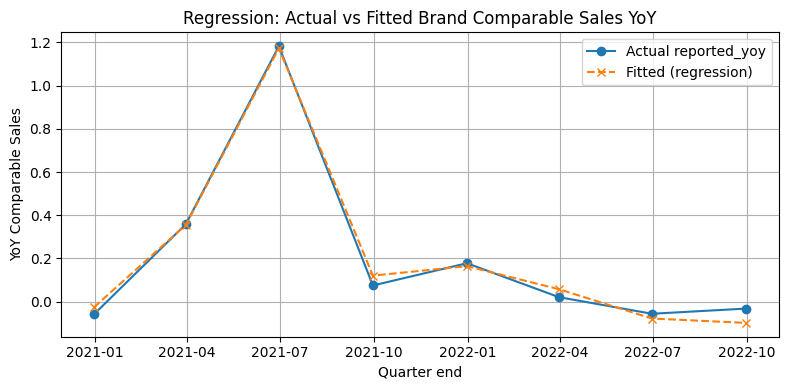

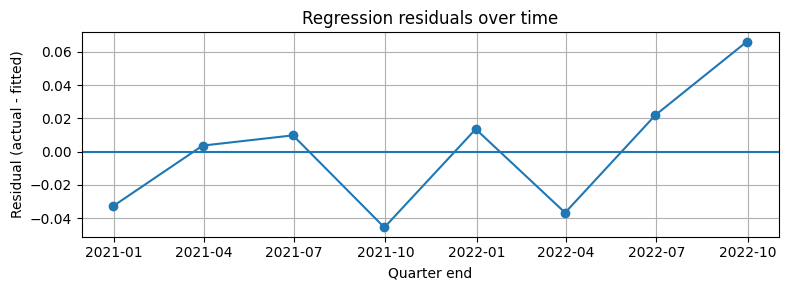

In [ ]:
# -------------------------------------------------------------------
# 10b. Plots for regression: actual vs fitted and residuals
# -------------------------------------------------------------------

# Sort by quarter_end_dt to get a nice time axis
plot_df = comp_rep_calib.sort_values("quarter_end_dt").copy()

# 1) Actual vs fitted
plt.figure(figsize=(8, 4))
plt.plot(plot_df["quarter_end_dt"], plot_df["reported_yoy"],
         marker="o", label="Actual reported_yoy")
plt.plot(plot_df["quarter_end_dt"], plot_df["pred_from_model"],
         marker="x", linestyle="--", label="Fitted (regression)")
plt.title("Regression: Actual vs Fitted Brand Comparable Sales YoY")
plt.xlabel("Quarter end")
plt.ylabel("YoY Comparable Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 2) Residuals over time
plot_df["residual"] = plot_df["reported_yoy"] - plot_df["pred_from_model"]

plt.figure(figsize=(8, 3))
plt.plot(plot_df["quarter_end_dt"], plot_df["residual"], marker="o")
plt.axhline(0.0)
plt.title("Regression residuals over time")
plt.xlabel("Quarter end")
plt.ylabel("Residual (actual - fitted)")
plt.grid(True)
plt.tight_layout()



In [ ]:


q4_2022 = pd.Timestamp("2022-12-31")

sample_q4_2022 = comp_quarter.loc[
    comp_quarter["quarter_end_dt"] == q4_2022, "sample_yoy"
].iloc[0]
print("Sample-based YoY for 2022-12-31:", sample_q4_2022)

X_new = pd.DataFrame({
    "const": [1.0],
    "sample_yoy": [sample_q4_2022],
})

# Get prediction + intervals at 95% confidence (alpha=0.05)
pred_res = model.get_prediction(X_new)
pred_frame = pred_res.summary_frame(alpha=0.05)

pred_frame 
